In [1]:
# access .py files
import sys
import os
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

In [2]:
# torch
import torch
import torch.nn as nn
import torch.nn.functional as F

# gpytorch
import gpytorch

# torch_geometric
import torch_geometric
from torch_geometric.nn import GINConv, global_mean_pool
from torch_geometric.nn.aggr import SumAggregation
from torch_geometric.utils.random import erdos_renyi_graph
from torch_geometric.data import Data

# misc
import pickle
import matplotlib.pyplot as plt
import networkx as nx
from typing import List, Callable, Tuple
from functorch import make_functional_with_buffers, jacrev

/Users/miles/.miniconda3/envs/bandits/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Graph Neural Network Bandits

This notebook tries to reproduce and understand the results from [Graph Neural Network Bandits](https://arxiv.org/pdf/2207.06456.pdf).

### Table of Contents
1. [GNN model definition](#GNN-model-definition) — a vanilla GNN in `pytorch_geometric` to compute graph representations

2. [Synthetic graph domains](#Synthetic-graph-domains) — sample random graphs to construct graph domains as described in paper.
3. [Compute empirical G-NTK](#Compute-empirical-NTK) — use jacobian contraction to compute the empirical Graph-NTK matrix for a subset of a graph domain ${\mathcal{G}_{p,N}}$.
4. [Gaussian process reward](#Gaussian-process-reward) —  Use a GP to learn a smooth reward function $f: \mathcal{G} \rightarrow \mathbb{R}$ and update the synthetic dataset $\{\mathcal{G}_i, f(\mathcal{G}_i)\}$.
5. [GNN-UCB](#GNN-UCB) — contextual bandits using the Graph-NTK and neural upper confidence bound (NeuralUCB) as the acquisition function.
---

## GNN model definition

The authors use GNNs to model a node permutation-invariant reward function. This will be a single conv-layer GCN with large width-$m$ hidden ReLU layers: $f_{\text{GNN}} (\mathcal{G}; \Theta): \mathcal{G} \rightarrow \mathbb{R}$. Weights are initialized with a standard normal.

* AGGREGATION: $\bar{h} = \frac{\sum_{\mathcal{i \in N(j)}} h_i}{c_j}$ where $c_j$ is the euclidean norm. The unit-norm assumption ensures the NTK is positive definite. This message-passing operation is equivalent to a normalized GINconv layer. We will precompute this though, meaning the input to the model is actually $\bar{h}_\mathcal{G}$ and not a graph object $\mathcal{G}$.
* BLOCK: $\frac{1}{\sqrt{m}}\sigma(f_\text{NN}(\bar{h}))$ is a hidden ReLU layer, then rescaled with $\frac{1}{\sqrt{m}}$ to ensure convergence and a closed form NTK.

Note that input is actually a precomputed node feature tensor (hbar) and not a `torch_geometric.data.Data` object.

In [3]:
from gnn import GNN

# show model state dict
model = GNN(width=2048)
print(model)

GNN(
  (f1): Linear(in_features=5, out_features=2048, bias=False)
  (f2): Linear(in_features=2048, out_features=1, bias=False)
)


## Synthetic graph domains
Generate a synthetic dataset as described in section *5. Experiments*. Modest parameters are used to reduce computational cost.

* 4 graph domains with Erdős–Rényi graphs parameterized by ($p, N$)
* $p \in [0.1, 0.25, 0.75]$
* $N \in [5, 10]$
* sample 200 graphs per domain $G_{p,N}$
* node features are in $\mathbb{R}^5$

`ENGraph` contains both the full graph representation (adj matrix) as well as precomputed aggr. node feature vectors $\bar{h}_j$

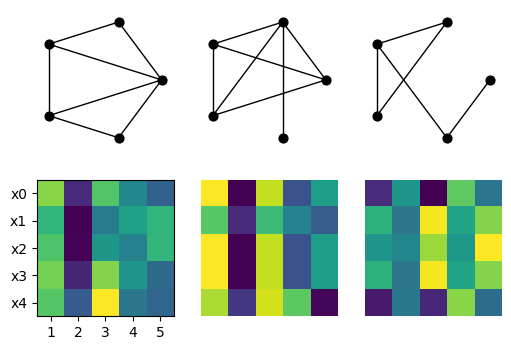

In [4]:
from utils import ENGraph

# sample some graph domains (20 graphs per domain)
graphs = {}
for p in [0.1, 0.25, 0.75]:
    for N in [5, 10]:
        graphs[(p,N)] = []
        for i in range(200):
            graphs[(p,N)].append(ENGraph(p, N))
            
# plot sampled graphs and their aggregated node feature matrices
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=[6, 4])
for idx, engraph in enumerate(graphs[(0.75, 5)][:3]):
    g = torch_geometric.utils.to_networkx(engraph.graph, to_undirected=True)
    axs[1, idx].imshow(engraph.hbar.detach().numpy())
    axs[1, idx].set_yticks(ticks = range(5), labels=[f"x{i}" for i in range(5)])
    axs[1, idx].set_xticks(ticks = range(5), labels=[i+1 for i in range(5)])
    if idx > 0: axs[1, idx].axis('off')
    nx.draw_circular(g, ax=axs[0, idx], node_size=40, node_color="black")
    
plt.savefig("test.svg", transparent=True)

### GNN as a GP
As a sanity check, we'll test whether large-width GNN does have approximately gaussian distributed outputs, reaffirming that in the infinite-width limit the GNN should converge to a gaussian process.

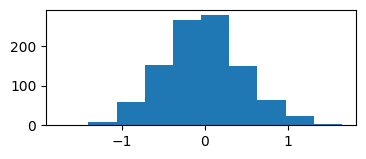

In [18]:
# init GNN
model = GNN(width=2048)
model.eval()

# reinit and re-evaluate 1000 times
hbar_test = graphs[(0.25, 5)][0].hbar
outs = []
for _ in range(1000):
    model.reinit()
    y = model(hbar_test)
    outs.append(y.detach().squeeze().item())

# show distribution of model outputs is normal
plt.figure(figsize=[4,1.5])
plt.hist(outs)
plt.savefig("test.svg", transparent=True)

## Compute empirical G-NTK

Here we compute the empirical G-NTK for a small subset of graph domain $\mathcal{G}_{0.25, 10}$ using jacobian contraction.

* Compute jacobians using `functorch`: $\mathbf{g}(\mathcal{G};\mathbf{\theta}_0) = \nabla_\theta{f_\text{GNN}(\mathcal{G})}$
* Compute NTK matrix for 5 graphs: $\mathbf{K} = \mathbf{G} \mathbf{G}^\top$

In the paper they explicitly show the relationship between the "vanilla" NTK and Graph-NTK by decomposing the GNN into FFNNs, making the deterministic Graph-NTK a function of the NTK.

* $\bar{h}_j$ aggregated node feature vec for node $j$
* $f_\text{GNN}(\mathcal{G}) = \frac{1}{N} \sum^N_{j=1} f_\text{NN}(\bar{h}_j)$, i.e. single conv-layer GNN is equivalent to an FFNN over aggregated node features
* $k_\text{GNN} = \frac{1}{N^2} \sum_{j, j' = 1}^N k_\text{NN}(\bar{h}_j, \bar{h}_{j'})$, GNN-NTK defined as a function of NTK

This would allow us to easily compute the Graph-NTK using a deterministic kernel. In practice, for these experiments we use the empirical G-NTK due to incompatibility of `torch` with the `neural-tangents` library.


In [6]:
from gnn import GNN

# init GNN
model = GNN(width=2048)
model.eval()

# evaluate one example
hbar_test = graphs[(0.25, 5)][0].hbar
y = model(hbar_test)
if y is not None:
    print(f"output shape: {y.size()}")
    print("predicted reward:", y.detach().item())

output shape: torch.Size([1, 1])
predicted reward: -0.5539193153381348


### Compute NTK matrix for 5 graphs

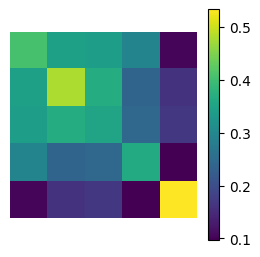

In [7]:
# sample 5 graphs from one domain (p=0.25, N=10)
train_G = torch.concat(
    [g.hbar.unsqueeze(0) for g in graphs[(0.25, 10)][:5]]
)

# compute empirical NTK matrix for 5 graphs
K = model.batchNTK(train_G, train_G)
fig = plt.figure(figsize=[3,3])
img = plt.imshow(K.detach().numpy())
fig.colorbar(img)
plt.axis("off")
plt.savefig("test.svg", transparent=True)

## Gaussian Process reward

For the synthetic dataset, the authors learn a smooth "true" reward function for each domain using a GP $f: G \rightarrow \mathbb{R}$. `gpytorch` requires tensor objects so we use the precomputed node features as input: $f: \bar{h}_G \rightarrow \mathbb{R}$.

* Use a GP prior $f \sim \text{GP}(0, K_{GNN})$
* Learn posterior GP with 5 graphs from a particular domain $(\mathcal{G}_i, y_i)_{i \leq 5} \in \mathcal{G}_{p,N}$, where $y_i$ are randomly sampled from $N(0,1)$
* Sample from smooth posterior GP to get $f(\mathcal{G}_i)$

The final dataset is then $\mathcal{D}_{p,N} = \{(\mathcal{G}_i, f(\mathcal{G}_i))|\mathcal{G}_{p,N} \}$

### Plotting 5 training samples from domain $\mathcal{G}_{0.25, 10}$

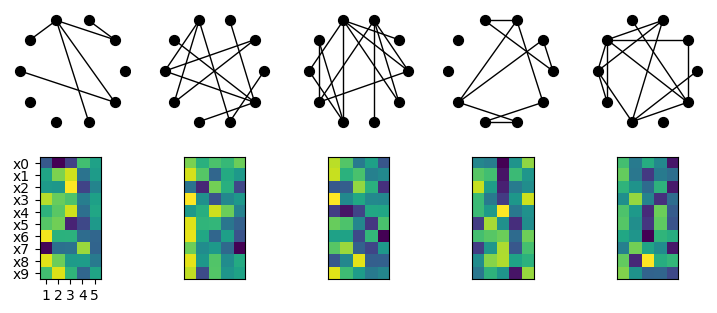

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=[9, 3.5])
for idx, engraph in enumerate(graphs[(0.25, 10)][:5]):
    g = torch_geometric.utils.to_networkx(engraph.graph, to_undirected=True)
    axs[1, idx].imshow(engraph.hbar.detach().numpy())
    axs[1, idx].set_yticks([])
    axs[1, idx].set_xticks([])
    axs[1, 0].set_yticks(ticks = range(10), labels=[f"x{i}" for i in range(10)])
    axs[1, 0].set_xticks(ticks = range(5), labels=[i+1 for i in range(5)])
    nx.draw_circular(g, ax=axs[0, idx], node_size=50, node_color="black")
    

plt.savefig("test.svg", transparent=True)

### Learn GP posterior and sample reward for each graph domain


In [9]:
from gp import GNTK, GP_reward

RESAMPLE = False

if RESAMPLE:
    # learn GP posterior and sample reward for dataset
    for domain in graphs.keys():
        # get 5 samples from domain
        train_x = torch.concat(
            [g.hbar.unsqueeze(0) for g in graphs[domain][:5]]
        ).flatten(1)
        train_y = torch.normal(torch.tensor([0.0]*5), torch.tensor([1.0]*5))

        # initialize likelihood and model
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        gp = GP_reward(
            train_x, train_y, likelihood, 
            model.batchNTK, x_shape=(domain[1], 5)
        )
        
        # set to train
        gp.train()
        likelihood.train()

        # init optimizer and loss
        optimizer = torch.optim.Adam(gp.parameters(), lr=0.1)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp)

        print(f"fitting GP for domain G{domain} ", end="")
        for i in range(100):
            optimizer.zero_grad()
            output = gp(train_x)
            loss = -mll(output, train_y)
            loss.backward()
            optimizer.step()
            if i%10==0: print(".",end="")

        # predict all graphs in domain
        gp.eval()
        test_x = torch.concat(
            [g.hbar.unsqueeze(0) for g in graphs[domain]]
        ).flatten(1)
        preds = gp(test_x).mean

        # update dataset
        print(" updating graphs")
        for g, y in zip(graphs[domain], preds):
            g.y = y
            
    # save updated dataset
    pickle.dump(graphs, open("../data/graphs.pkl", "wb"))
else:
    # load precomputed dataset with GP reward
    graphs = pickle.load(open("../data/graphs.pkl","rb"))

## GNN-UCB

### Background
The authors propose to use the Graph-NTK to balance exploitation, i.e. training of GNN, and exploration of arms, i.e. acquiring new samples $(\mathcal{G}_i, y_i)$. In the lazy (overparameterized) regime, neural networks are essentially gaussian processes, which allows one to quantify the upper uncertainty bound (UCB) of a GNN with the NTK. For simplicity and understanding we will only implement a variant of NeuralUCB, GNN-UCB.

* $\text{UCB}(\mathcal{G}; \mu, \sigma) = \mu(\mathcal{G}) + \beta_t\sigma(\mathcal{G})$ is the acquisition function
* $\mu \triangleq f_\text{GNN}$ is straightforward, now how to quantify $\sigma$?
* recall GP posteriors admit a closed form for $k(x^*, x^*) = k^\top_{X,x^*}(K_{XX}+\sigma^2I)^{-1}k_{X,x^*}$

Brief overview of contextual bandits and Linear-UCB for understanding. Please refer to *section 4.* on regret analysis in the [NeuralUCB paper](https://arxiv.org/pdf/1911.04462.pdf), the original [LinUCB paper](https://arxiv.org/pdf/1003.0146.pdf), or a [lecture on linear bandits](https://sites.cs.ucsb.edu/~yuxiangw/classes/RLCourse-2021Spring/Lectures/scribe_linear_bandit.pdf) for in-depth background.

* $y_t = f(\mathbf{x}_t) + \epsilon_t$. One observes the reward $y_t$ from a function with some noise. In this case just linear regression: $f(\mathbf{x}_t) = \mathbf{w}^\top \mathbf{x}$. Here $\mathbf{x}$ is called the "context".
* Assuming a ridge loss, we have the closed form estimate for the model: $\hat{\mathbf{w}}_t = (X_tX_t^\top + \lambda I)^{-1}X_t^\top y$. Notice that $K = X_tX_t^\top$ is the kernel matrix.
* The cumulative regret is $R_T = \sum^T_{t=1} |f^*(x_t) - f(x_t)|$, this should be bounded for the algorithm to converge.
* Omitting the proof, the error of predictions are bounded by the (scaled) standard deviation of the expected reward: $|f^* - f| \leq \beta_t \sqrt{\mathbf{x}_t^\top (\lambda I + K)^{-1} \mathbf{x}_t}$
* This uncertainty bound can then be used in the vanilla UCB acquisition function $\text{UCB}(x_t) = f(x_t) + \beta_t \sqrt{\mathbf{x}_t^\top (\lambda I + K)^{-1} \mathbf{x}_t}$

For GNN-UCB:
* Can understand $\mathbf{g}(\mathcal{G})$ as a basis function $\phi(\mathcal{G})$
* Here $K = GG^\top /{m}$, is the gram matrix normalized by the layer width $m$
* Analogous to LinUCB, the uncertainty can be understood as enforcing a bound on the cumulative regret $R_T$.

$$\text{GNN-UCB}(\mathcal{G_t}) = f_\text{GNN}(\mathcal{G_t};\theta_{t-1}) + \beta_t \sqrt{\mathbf{g}(\mathcal{G_t};\theta_{t-1})^\top(\lambda I+K)^{-1}\mathbf{g}(\mathcal{G_t};\theta_{t-1})/m}$$

### Practical implementation

Using modified instructions specified in *Appendix D.2, D.3*.

* Invert $\hat{K} =(\lambda I + GG^\top)$ by first approximating it with a diagonal matrix $diag(\hat{K})$ 
* We store $\hat{K}$ as a flat tensor. Since $\hat{K}$ is a diag, we approximate $g^\top \hat{K} g$ with $g^\top diag(\hat{K}) \odot g$
* "explore" for $T_0$ steps with random samples of $G_i$ to pre-train
* For the subsequent $T_1$ steps train but re-init model parameters at each step
* Use $\beta = 0.1$ and $\lambda=0.0025$
* Stop if relative $\Delta L_{k}/\Delta L_{k-1} \leq .05$
* Stop if gradient steps $k$ exceeds acquisition time-step $t$

GNN training:
* use $m=2048$, $L=2$ with gaussian weight init for the GNN
* use `MSELoss`: $\mathcal{L}(\theta) = \frac{1}{t}\sum_{i<t} (f_\text{GNN}(\mathcal{G}_i;\theta_t) - y_i)^2$, no L2-reg since we don't use weight decay: $m\lambda \|\theta - \theta^{(0)}\|_2^2$
* use `Adam` optimizer (`lr=0.001`) instead of `SGD` (not theoretically correct but practical)
* train network for gradient steps $J_t = \min J$ such that $\mathcal{L}(\theta_{t-1})\leq 10^{-4}$ or the relative change in loss is less than $10^{-3}$

In [10]:
class GNNUCB:
    def __init__(
            self,
            model: GNN,
            lambd: float = .0025, 
            beta: float = .1,
            m: int = 512,
            T: int = 100
        ):
        '''Util class for computing + updating the acquisition func.
        ---
        PARAMS
        mode: GNN model w/ a lazy jacobian method
        lambd: regularization param
        beta: uncertainty scaling factor
        m: hidden layer width
        '''
        # callables
        self.jac0 = model.jac0
        
        # constants
        self.lambd = lambd
        self.beta = beta
        self.m = m
        
        # init exploration bonus matrix
        num_params = sum([p.numel() for p in model.parameters()])
        self.K = lambd * torch.ones(num_params)
        self.K_inv = torch.tensor(1.) / self.K
        
    def update_K(self, hbar: torch.Tensor) -> None:
        '''Updates the exploration bonus matrix.
        ---
        PARAMS
        hbar: aggr node feature matrix of graph, shape (N, D)
        '''
        g = self.jac0(hbar)
        self.K += torch.diag(torch.outer(g, g)/self.m)
        self.K_inv = torch.tensor(1.) / self.K

    def __call__(self, mu: torch.Tensor, hbar: torch.Tensor) -> torch.Tensor:
        '''GNN-UCB acquisition function.
        ---
        PARAMS
        hbar: precomputed aggr node feature matrix of graph Gi
        model: GNN model w/ batchNTK() method
        ---
        returns optimistic outcome of choosing graph Gi
        '''
        g = self.jac0(hbar)
        sigma = self.beta * torch.sqrt(torch.dot(g,  self.K_inv * g)/self.m)
        return mu + sigma

### Plot model prediction and UCB

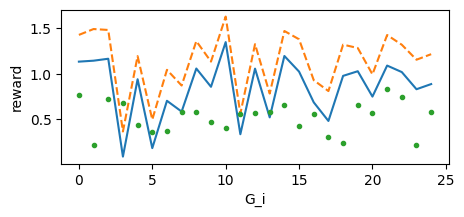

In [11]:
import collections
from utils import GraphData

SIZE = 25
model.reinit()
ucb = GNNUCB(model, beta=.5)
# load data
graphs = pickle.load(open("../data/graphs.pkl","rb"))
data = GraphData(graphs[(0.25, 10)])

f_G = [model(g.hbar).item() for g in data.domain[:SIZE]]
y_G = [g.y.item() for g in data.domain[:SIZE]]
U_G = [ucb(f_G, g.hbar).item() for f_G, g in zip(f_G, data.domain[:SIZE])]
plt.figure(figsize=[5,2])
plt.plot(f_G)
plt.plot(U_G, '--')
plt.plot(range(SIZE), y_G, '.')
plt.ylabel("reward")
plt.xlabel("G_i")
plt.savefig("test.svg", transparent=True)

In [13]:
import collections
from utils import GraphData

#--- SETUP

# init GNN
model = GNN( width=2048)
model.eval()

# init training setup
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()
loss_0 = torch.tensor(2e-3)

# load data
graphs = pickle.load(open("../data/graphs.pkl","rb"))
data = GraphData(graphs[(0.25, 10)])
y_max = torch.max(torch.tensor([g.y for g in data.domain]))
    
# init acquisition function
ucb = GNNUCB(model, beta=.3)

def explore(data: GraphData, model: GNN, ucb: GNNUCB, t: int) -> torch.Tensor:
    '''
    data: graph domain object
    model: GNN model object
    ucb: acquisition object
    t: timestep
    ---
    returns reward of selected graph and adds it to train data
    '''
    # evaluation
    model.eval()
    
    # get max_G UCB(G)
    best = (-torch.tensor(float('inf')), None)
    for g_id, graph in enumerate(data.domain):
        mu = model(graph.hbar).squeeze()
        u = ucb(mu, graph.hbar)
        if u > best[0]:
            best = (u, g_id)

    # add to sample
    best_graph = data.domain[best[1]]
    data.train.add(best_graph)
    
    # update uncertainty bound w/ new graph
    ucb.update_K(best_graph.hbar)
    
    return best_graph.y
    

def train(optimizer, criterion, loss_0, data, model, max_t, log=False,) -> collections.OrderedDict:
    '''Training until stopping criterion is reached'''
    # track loss
    loss = loss_0
    last_loss = 5.
    losses = []
    
    model.reinit()
    model.train()
    for k in range(max_t):
        # get train data and labels
        train_data = data.train_data()
        train_targets = data.train_targets()

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # compute loss
        outputs = model(train_data)
        loss = criterion(outputs, train_targets)
        
        # check a simplified stopping criterions
        if k <= 20:
            delta_L = torch.absolute(last_loss - loss)
            last_loss = loss
            losses.append(loss.item())
            pass
        elif loss.item() <= loss_0.item():
            return model.state_dict()
        elif torch.abs(last_loss - loss)/delta_L <= .05:
            return model.state_dict()
        else:
            delta_L = torch.absolute(last_loss - loss)
            last_loss = loss
            losses.append(loss.item())

        # step
        loss.backward()
        optimizer.step()
        if log: print(".",end="")
    return model.state_dict()
    

regrets = []
    
# randomly explore domain to pretrain
print("random exploration (40 steps)")
for t in range(40):
    sample_idx = torch.randint(len(data.domain)-1, size=(1,1))
    data.train.add(data.domain[sample_idx])
    regrets.append(y_max - y)
    
# "exploration and exploitation"
print("explore and exploit",end="")
for t in range(40, 160):
    # explore (pick graphb from domain using prev model)
    y = explore(data, model, ucb, t)
    regrets.append(y_max - y)
    
    # exploit (train GNN)
    if t%5==0:
        print(f"\nt={t}, regret={y_max-y:.3f}")
        log = True
    params_t = train(optimizer, criterion, loss_0, data, model, t, log)
    log = False 

random exploration (40 steps)
explore and exploit
t=40, regret=0.467
........................................
t=45, regret=0.308
.............................................
t=50, regret=0.054
..................................................
t=55, regret=0.052
.......................................................
t=60, regret=0.165
............................................................
t=65, regret=0.113
.................................................................
t=70, regret=0.000
......................................................................
t=75, regret=0.000
...........................................................................
t=80, regret=0.000
................................................................................
t=85, regret=0.054
.....................................................................................
t=90, regret=0.113
..........................................................................................
t=95, regret=0.

### Plot cumulative regret

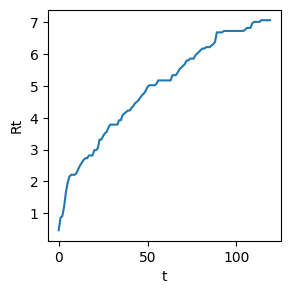

In [15]:
Rt = 0
ctr = []
for r in regrets[40:]:
    Rt += r
    ctr.append(Rt.item())

plt.figure(figsize=[3,3])
plt.plot(ctr)
plt.xlabel("t")
plt.ylabel("Rt")
plt.savefig("test.svg", transparent=True)